<a href="https://colab.research.google.com/github/abialbon/pytorch-udacity-scholarship/blob/master/Style_transfer/Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install pillow==5.3.0

# Style Transfer Steps

1. Get the images and visualize them
2. Transform the images into tensors suitable for the model
3. Download VGG19 model.features
4. Free the model


In [0]:
from PIL import Image
import numpy as np

content = Image.open('1*tUCgN7QSG-Q8T1HOZsOljA.jpeg')
style = Image.open('bae18c8706ed6748aa6c87b9d3bada8f--oil-painting-on-canvas-oil-paintings.jpg')

#content = np.asarray(content)
#style = np.asarray(style)

In [0]:
def image_convert(tensor):
    i = tensor.cpu().detach()
    i = i.numpy()
    i = i.transpose(1, 2, 0)
    i = i * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    i = i.clip(0, 1)
    return i

Text(0.5,1,'Style image')

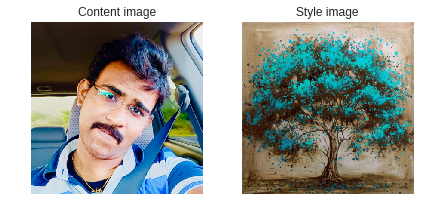

In [238]:
import torch
from torchvision import transforms

transform = transforms.Compose([transforms.Resize(400),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

content = transform(content)
style = transform(style)

%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[0].imshow(image_convert(content))
ax[0].axis('off')
ax[0].set_title('Content image')
ax[1].imshow(image_convert(style))
ax[1].axis('off')
ax[1].set_title('Style image')

In [204]:
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.models as models

model = models.vgg19(pretrained=True).features

for param in model.parameters():
    param.requires_grad = False
    
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
layers_we_need = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
}

In [0]:
def get_features(img, model):
    x = img.view(1, *img.shape)
    x = x.to(device)
    features = {}
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers_we_need:
            features[layers_we_need[name]] = x
            
    return features

content_features = get_features(content, model)
style_features = get_features(style, model)


def get_gram_matrix(tensor):
    b, d, w, h = tensor.shape
    
    x = tensor.reshape(d, w * h)
    g = torch.mm(x, x.t())
    return g

In [0]:
from torch import optim

content = content.to(device)
style = style.to(device)

target = content.clone().requires_grad_(True).to(device)

optimizer = optim.Adam([target], lr=0.003)

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

content_features = get_features(content, model)
style_features = get_features(style, model)
style_grams = {layer: get_gram_matrix(style_features[layer]) for layer in style_weights}

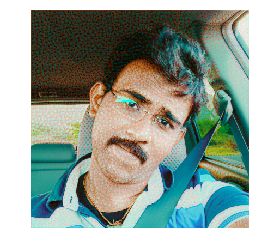

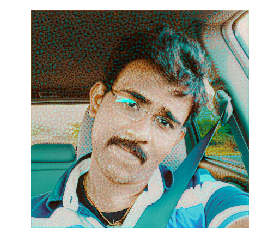

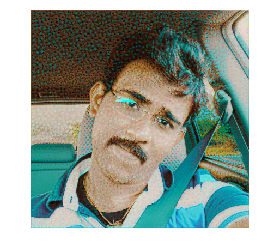

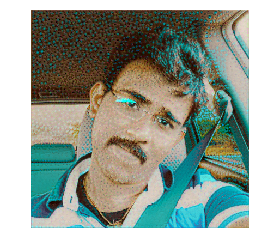

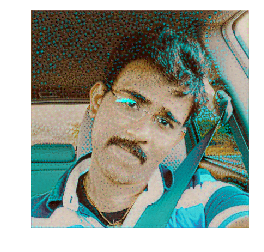

In [240]:
steps = 2000

for step in range(1, steps+1):

    target_features = get_features(target, model)    
    content_loss = torch.mean((content_features['conv4_2'] - target_features['conv4_2'])**2)
    
    style_loss = 0
    
    for layer in style_weights:
        _, d, w, h = target_features[layer].shape
        target_gram = get_gram_matrix(target_features[layer])
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_grams[layer])**2) 
        style_loss += layer_style_loss / d * w * h
        
    total_loss = content_weight * content_loss + style_loss * style_weight
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if step % 400 == 0:
        i = image_convert(target)
        plt.imshow(i)
        plt.axis('off')
        plt.show()

In [0]:
i = image_convert(target)
import matplotlib
matplotlib.image.imsave('name2.jpg', i)

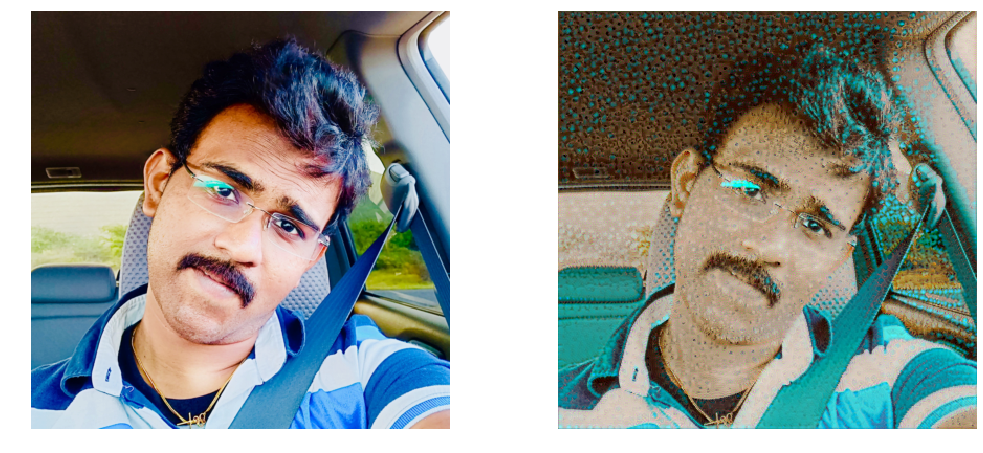

In [241]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_convert(content))
ax2.imshow(image_convert(target))
fig.tight_layout()
ax1.axis('off')
ax2.axis('off')
fig.set_size_inches(15, 10)